In [44]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import random
import sys 

import tensorly as tl
from tensorly.decomposition import non_negative_parafac
import scipy.sparse

In [45]:
def Qmat(S,configuration,path):
    dirname = os.fsdecode(configuration)
    filename = os.path.join(path, dirname+'/coords.csv_sparse_graph.npz')
    if os.path.isfile(filename): 
        A = scipy.sparse.load_npz(filename)
        '''construct modularity matrix'''
        M = A
        k = A.sum(axis=0)
        w = A.sum(axis=None)
        M = A - np.outer(k,k)*0.5/w
        output = M.shape[0]*M.shape[1]*np.trace(np.dot(np.dot(S.transpose(),M),S))/(2.0*w) #rescale by network size
    else:
        output = np.zeros(shape=(3043,3043))
    return output

def sample_modularity(S,cf_samples,path):
    modularity_values = []
    for configuration in cf_samples:
            modularity_values.append(Qmat(S,configuration,path))  
    return modularity_values

def random_community(Sp,configuration,path):
    np.random.shuffle(Sp)
    return Qmat(Sp,configuration,path)

def membership(factors):
    S = np.zeros(shape=factors[1][1].shape)
    for c in range(S.shape[1]):
        vec = 0.5*(factors[1][1][:,c]+factors[1][2][:,c]) # take the average of the 2 factors, that should be identical
        S[:,c] = vec/tl.norm(vec,1) #normalize membership
    Sp = np.copy(S) # this copy can be used for significance testing
    return S,Sp

In [46]:
import pickle as pkl

samples = 1000
rank = 20 
# comm = 20 
ind = 1
factor_list = []
path = '/media/garner1/hdd1/gpseq/10000G'

fileName = '/media/garner1/hdd1/gpseq/info_10000G/nnparafac' + '_rank' + str(rank) + '_sample' + str(ind) + '_size' + str(samples) + '.pkl'
fileObject = open(fileName, 'rb')
factors = pkl.load(fileObject)
fileObject.close()

fileName = '/media/garner1/hdd1/gpseq/info_10000G/cf-sampled' + '_rank' + str(rank) + '_sample' + str(ind) + '_size' + str(samples) + '.pkl'
fileObject = open(fileName, 'rb')
config_sample = pkl.load(fileObject)
fileObject.close()

In [47]:
S, Sp = membership(factors)
# with open('gpseq_rank25_samples100.pkl', 'wb') as f:
#     pkl.dump(S, f)

# np.savetxt("gpseq_rank20_samples1000.csv", S, delimiter=",")
# np.savetxt("hic_rank20_samples1000.csv", S, delimiter=",")

In [12]:
h1 = sample_modularity(S[:,comm],config_sample,path) # S on the training data

In [6]:
h2 = sample_modularity(S,random.sample(os.listdir(path), k=100),path) # S on the test data
mu_test = np.mean(h2); sigma_test = np.std(h2)

In [7]:
h3 = [random_community(Sp,config_sample[ind],path) for ind in range(100)] # random S on one of the training data
mu_null = np.mean(h3); sigma_null = np.std(h3)

In [12]:
'''evaluate the distribution of modularity for each community'''
h1 = [sample_modularity(S[:,comm],config_sample[:100],path) for comm in range(S.shape[1])] # S on the training data

In [23]:
h2 = [[sample_modularity(S[:,comm],random.sample(os.listdir(path), k=100),path)] for comm in range(S.shape[1])]

In [48]:
hmean=[np.mean(h) for h in h2]
top=np.asfarray(hmean).argsort()[-20:][::-1]
print(top)
print([hmean[t] for t in top])

[ 5 10 19 13  1  9 17  2 14 15  6  0  8  7  3 12  4 11 16 18]
[5.37439722643163, 5.020160213393587, 4.891403531302407, 4.6191206317480145, 4.402239192901268, 4.3765033128059505, 4.096732916109985, 3.7907440487560184, 3.518370769577294, 3.402069780483065, 3.1014937799204305, 3.0448534144214108, 3.0328122147734327, 2.8245192850388934, 2.755449115094357, 2.7319173139807034, 2.70278560684537, 2.6973000384605132, 2.509918290879194, 2.4334870636399386]


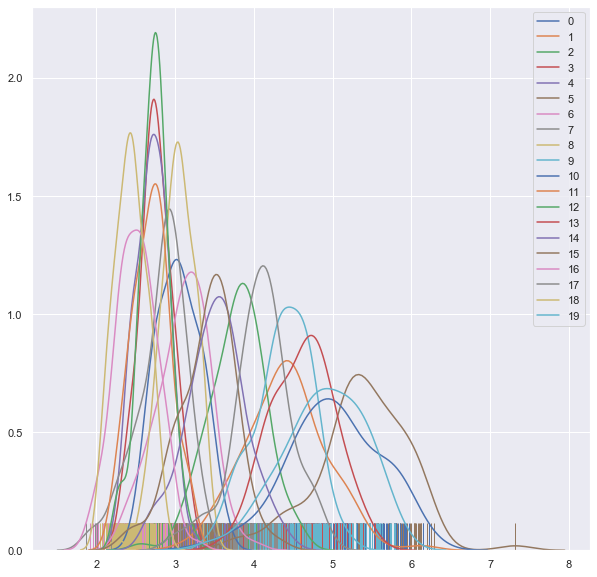

In [49]:
sns.set(rc={'figure.figsize':(10,10)})
labels = [str(comm) for comm in range(S.shape[1])]
fig, ax = plt.subplots()
for count in range(S.shape[1]):
    sns.distplot(h2[count], rug=True, hist=False,label=labels[count])
    
    
# plt.legend()
# plt.title('HiC+GPSeq only with model significance '+str(np.round((mu_test-mu_null)/(sigma_test+sigma_null))))
# print('z-score is: '+str((ref-mu)/sigma))  # z-score for a random S as the null model

Text(0.5, 1.0, 'HiC+GPSeq only with model significance 36.0')

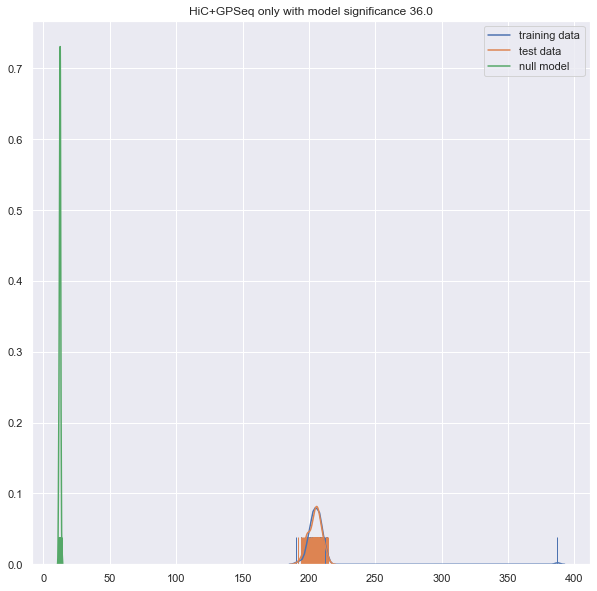

In [8]:
sns.set(rc={'figure.figsize':(10,10)})
labels = ['training data','test data', 'null model']
histos = [h1,h2,h3]
with open('with-gpseq-histos.pkl', 'wb') as f:
    pkl.dump(histos, f)
    
fig, ax = plt.subplots()
for count in range(3):
#     sns.distplot(histos[count], kde=False,norm_hist=True,label=labels[count],hist_kws=dict(alpha=0.7))
    sns.distplot(histos[count], rug=True, hist=False,label=labels[count])
    
plt.legend()
plt.title('HiC+GPSeq only with model significance '+str(np.round((mu_test-mu_null)/(sigma_test+sigma_null))))
# print('z-score is: '+str((ref-mu)/sigma))  # z-score for a random S as the null model

8.217588


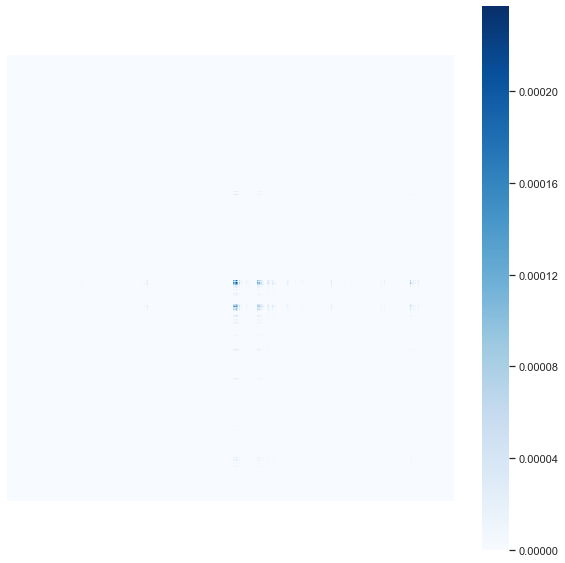

8.350695


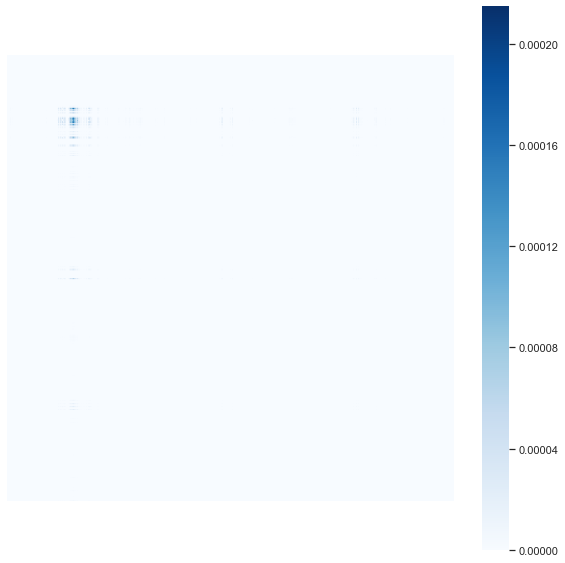

7.9290338


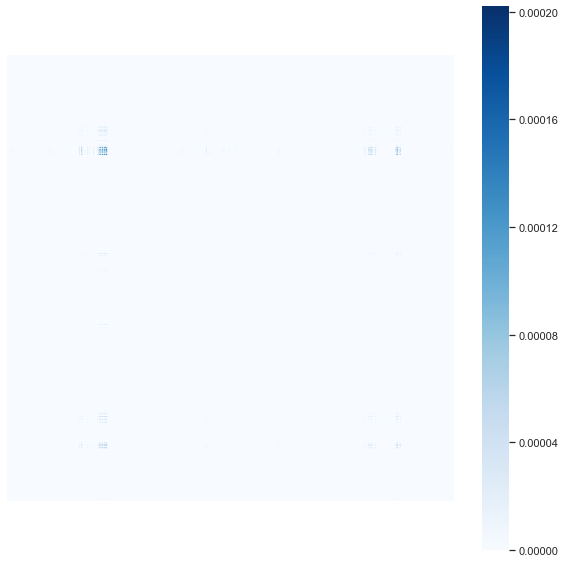

7.41763


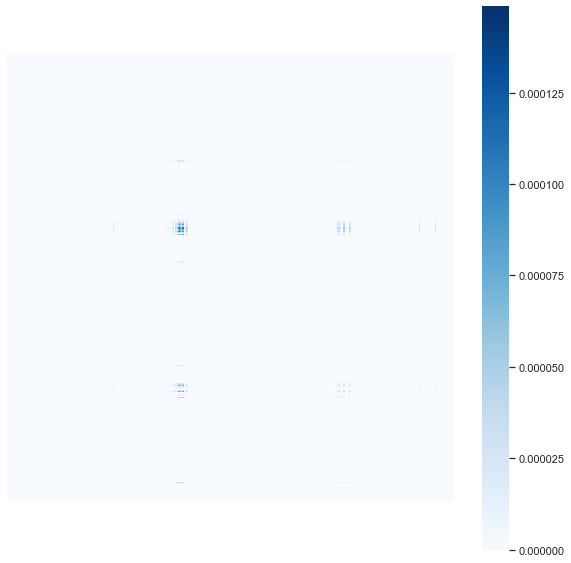

4.438285


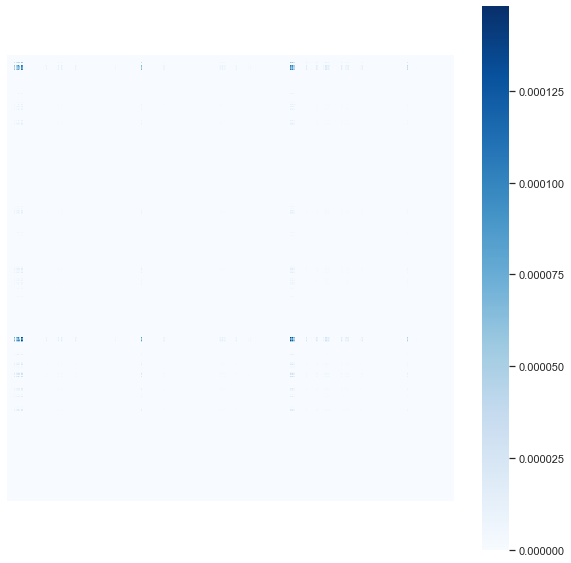

8.261875


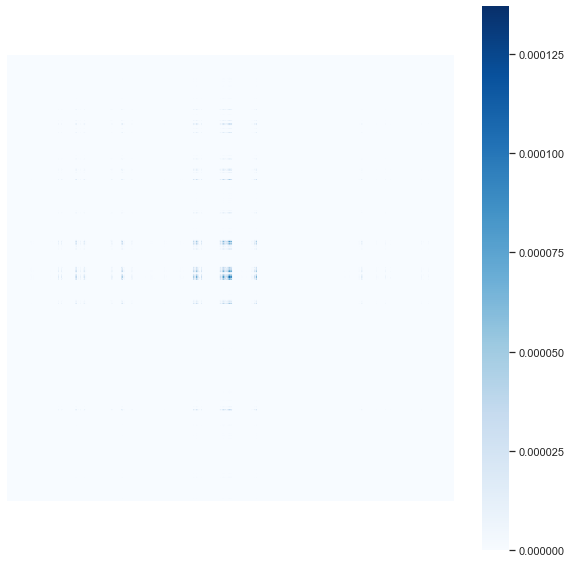

7.921939


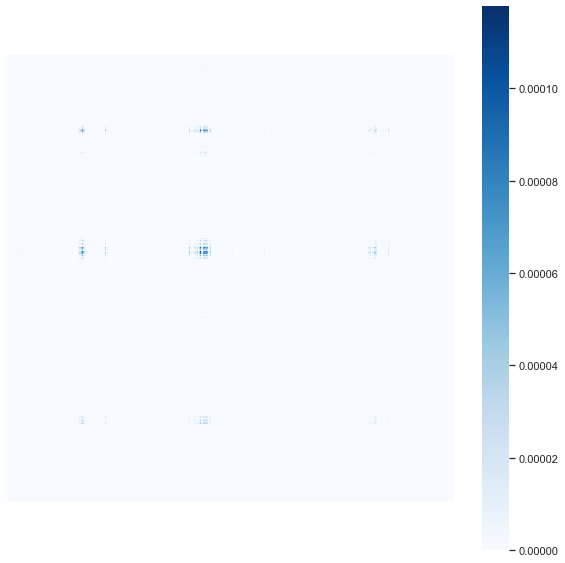

7.876041


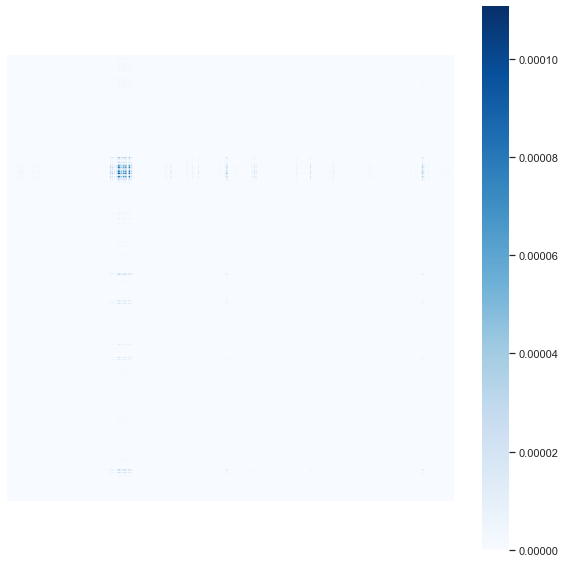

7.839333


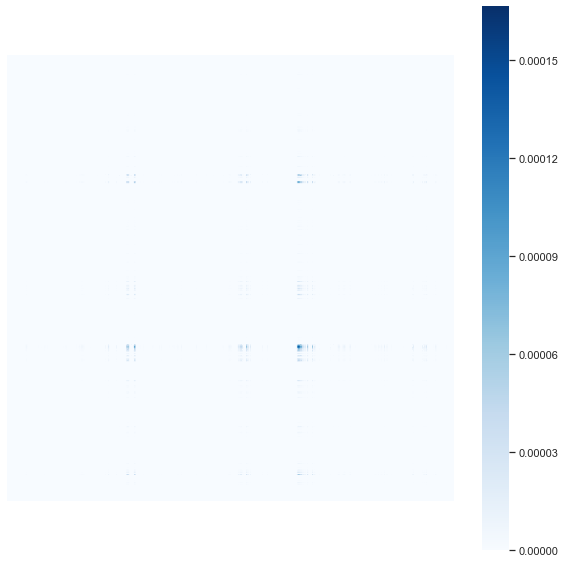

7.6308436


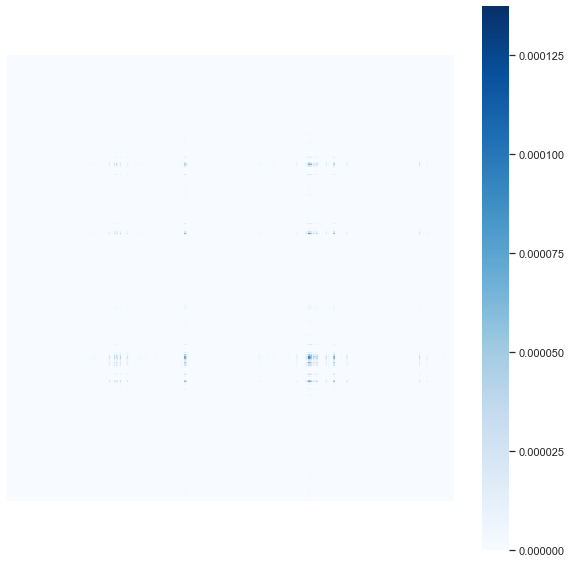

7.3240633


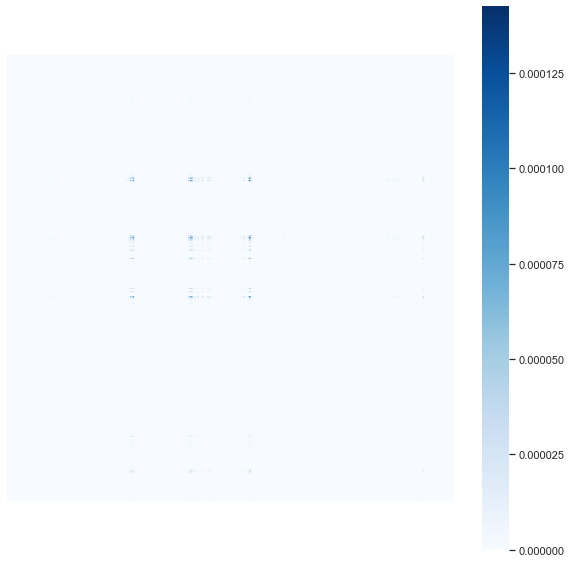

7.4728107


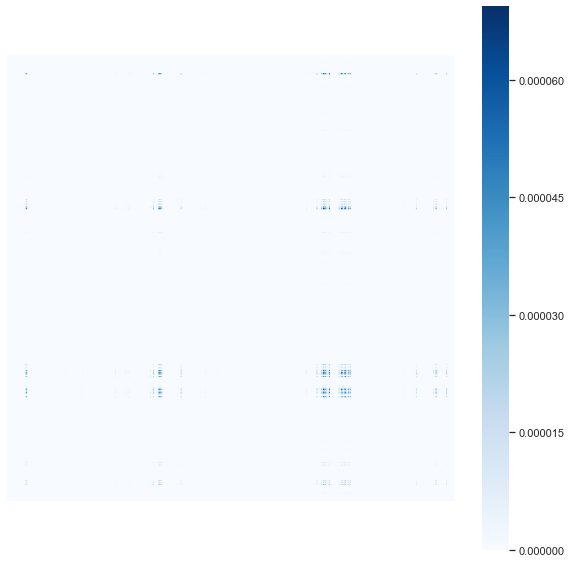

8.044625


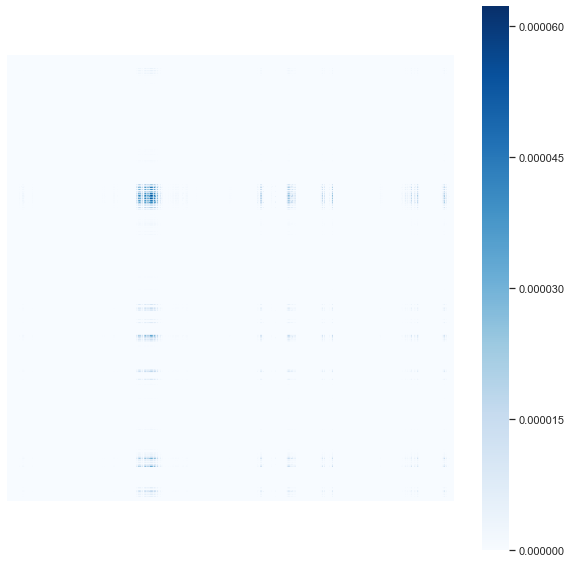

7.668841


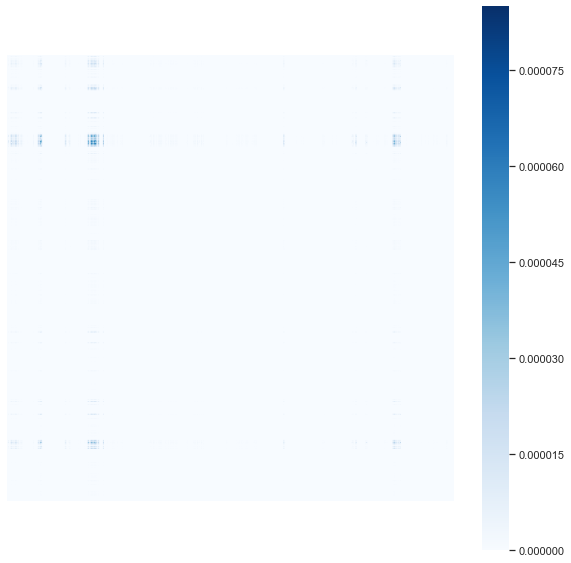

7.761797


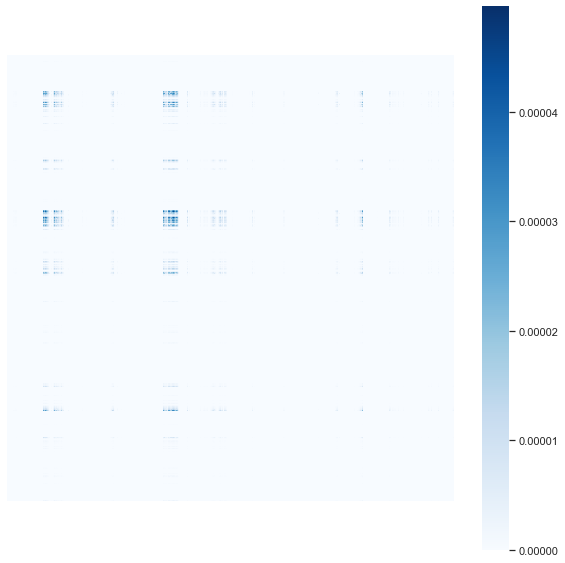

7.7212405


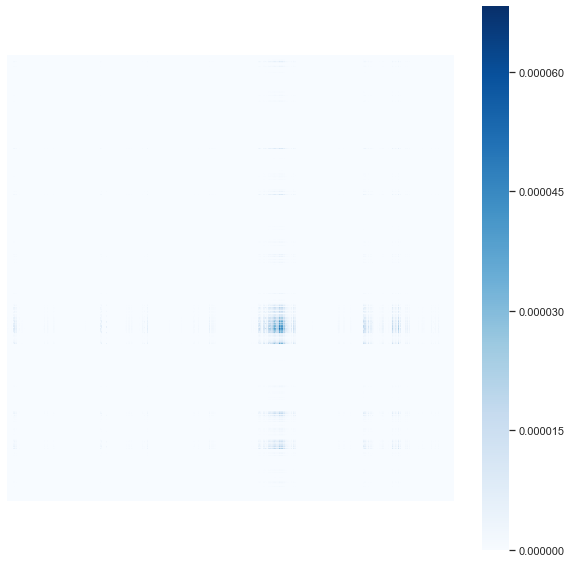

7.7677603


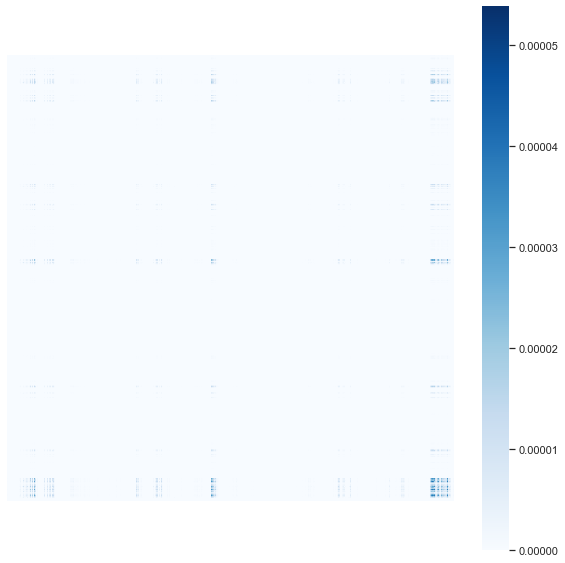

7.360014


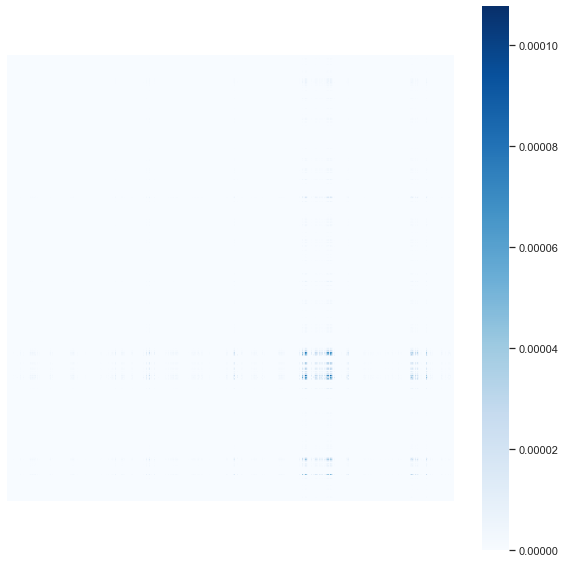

7.4758906


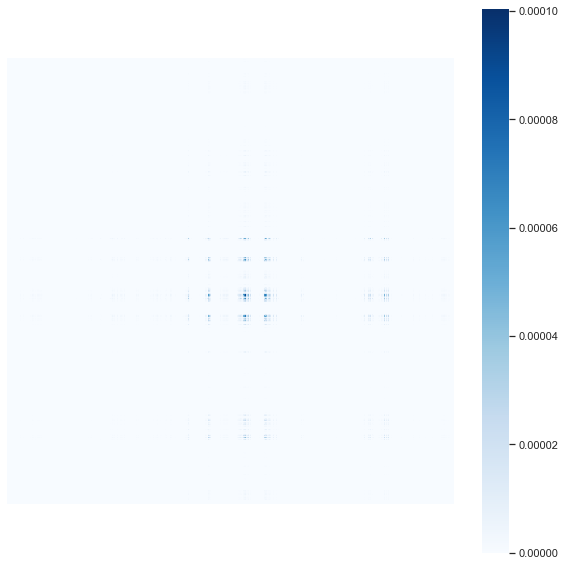

7.6656985


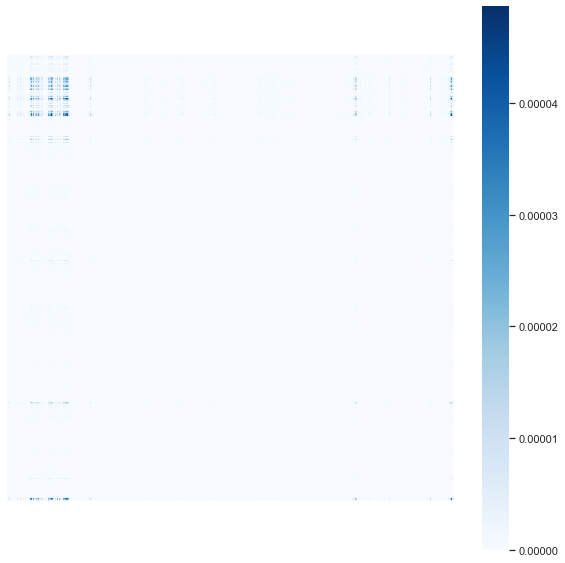

In [51]:
for i in top:
    a = factors[1][1][:,i]
    b = factors[1][2][:,i]
    c = factors[1][0][:,i]
    mat = np.outer(S[:,i],S[:,i]) # symmetrize wrt a & b
    print(tl.norm(a,2)*tl.norm(b,2)*tl.norm(c,2))
#     plt.imshow(mat, cmap='Blues', interpolation='nearest')
    plt.figure(figsize=(10, 10))
    sns.heatmap(mat,cmap='Blues',square=True,xticklabels=False,yticklabels=False)
    plt.show()  
